<a href="https://colab.research.google.com/github/Chehan2004/DSGP_GROUP_36/blob/treatments_and_recommendations/Fertilizer%26Pesticide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 25) #to display all columns

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tea_leaf_dataset_disease_fertilizer_expanded.csv")
df.head()


,Sample ID,Leaf Color,Leaf Texture,Soil pH,Moisture (%),Temp (°C),Pest Type,Nutrient Deficiency,Recommended Fertilizer,Fertilizer Dosage (kg/ha),Recommended Pesticide,Pesticide Dosage (ml/L),Unnamed: 12,Unnamed: 13
0,T001,Brownish,Smooth,5.3,16.0,31.0,Leaf roller,Nitrogen,Urea (46-0-0),100.0,Lambda-cyhalothrin 2.5% EC,0.8,NaN,NaN
1,T002,Brownish,Curled,4.7,27.0,30.0,Tea mosquito bug,Magnesium,Epsom Salt (MgSOâ‚„),60.0,Imidacloprid 17.8% SL,0.5,NaN,NaN
2,T003,Brownish,Curled,4.2,28.0,32.0,Red spider mite,Potassium,MOP (0-0-60),80.0,Abamectin 1.8% EC,1.5,NaN,NaN
3,T004,Light green,Brittle,4.2,25.0,25.0,Thrips,NaN,NPK 15-15-15 (balanced),60.0,Chlorpyrifos 20% EC,1.0,NaN,NaN
4,T005,Pale green,Normal,6.0,29.0,20.0,Tea mosquito bug,Potassium,MOP (0-0-60),80.0,Imidacloprid 17.8% SL,0.5,NaN,NaN


In [4]:
# to remove duplicates
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

No duplicate rows found

Removing unnecessary features

In [5]:
df.drop("Unnamed: 12", axis=1, inplace=True)
df.drop("Unnamed: 13", axis=1, inplace=True)
df.drop("Sample ID", axis=1, inplace=True)
df.head()

,Leaf Color,Leaf Texture,Soil pH,Moisture (%),Temp (°C),Pest Type,Nutrient Deficiency,Recommended Fertilizer,Fertilizer Dosage (kg/ha),Recommended Pesticide,Pesticide Dosage (ml/L)
0,Brownish,Smooth,5.3,16.0,31.0,Leaf roller,Nitrogen,Urea (46-0-0),100.0,Lambda-cyhalothrin 2.5% EC,0.8
1,Brownish,Curled,4.7,27.0,30.0,Tea mosquito bug,Magnesium,Epsom Salt (MgSOâ‚„),60.0,Imidacloprid 17.8% SL,0.5
2,Brownish,Curled,4.2,28.0,32.0,Red spider mite,Potassium,MOP (0-0-60),80.0,Abamectin 1.8% EC,1.5
3,Light green,Brittle,4.2,25.0,25.0,Thrips,NaN,NPK 15-15-15 (balanced),60.0,Chlorpyrifos 20% EC,1.0
4,Pale green,Normal,6.0,29.0,20.0,Tea mosquito bug,Potassium,MOP (0-0-60),80.0,Imidacloprid 17.8% SL,0.5


Handling missing values

In [6]:
# Replacing common missing strings with real NaNs

df = df.replace(["N/A", "none", "None", "-", ""], np.nan)
df.isna().sum()

,0
Leaf Color,14
Leaf Texture,14
Soil pH,14
Moisture (%),14
Temp (°C),14
Pest Type,109
Nutrient Deficiency,110
Recommended Fertilizer,14
Fertilizer Dosage (kg/ha),14
Recommended Pesticide,109


In [7]:
#numeric missing values >>> median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# categorical missing >>> mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [8]:
df.isna().sum()

,0
Leaf Color,0
Leaf Texture,0
Soil pH,0
Moisture (%),0
Temp (°C),0
Pest Type,0
Nutrient Deficiency,0
Recommended Fertilizer,0
Fertilizer Dosage (kg/ha),0
Recommended Pesticide,0


In [9]:
df.shape

(514, 11)

In [10]:
df["Soil_Acidic_Flag"] = df["Soil pH"].apply(lambda x: 1 if x < 5.5 else 0)
df["pH_Deviation"] = abs(df["Soil pH"] - 5.5)
df["Temp_Normalized"] = (df["Temp (°C)"] - df["Temp (°C)"].mean()) / df["Temp (°C)"].std()
df["Moisture_Normalized"] = (df["Moisture (%)"] - df["Moisture (%)"].mean()) / df["Moisture (%)"].std()

In [11]:
def health_score(row):
    score = 0

    # leaf color impact
    if row["Leaf Color"].lower() in ["yellow", "brown"]:
        score -= 2
    else:
        score += 1

    # moisture stress
    if row["Moisture (%)"] < 30:
        score -= 1

    # pH
    if row["Soil pH"] < 5.0:
        score -= 1

    return score

df["Health_Score"] = df.apply(health_score, axis=1)

In [12]:
df["Moisture_Temp_Interaction"] = df["Moisture (%)"] * df["Temp (°C)"]
df["pH_Deficiency_Interaction"] = df["Soil pH"] * df["Nutrient Deficiency"].astype("category").cat.codes

In [13]:
label_enc = LabelEncoder()

for col in ["Leaf Color", "Leaf Texture", "Pest Type", "Nutrient Deficiency"]:
    df[col + "_Encoded"] = label_enc.fit_transform(df[col])

In [14]:
features = [
    "Soil pH", "Moisture (%)", "Temp (°C)", # Corrected column name
    "Soil_Acidic_Flag", "pH_Deviation", "Temp_Normalized",
    "Moisture_Normalized", "Health_Score",
    "Moisture_Temp_Interaction", "pH_Deficiency_Interaction",
    "Leaf Color_Encoded", "Leaf Texture_Encoded",
    "Pest Type_Encoded", "Nutrient Deficiency_Encoded"
]


X = df[features]

y = df["Recommended Pesticide"]   #  recommends fertilizer

In [15]:
df.head()

,Leaf Color,Leaf Texture,Soil pH,Moisture (%),Temp (°C),Pest Type,Nutrient Deficiency,Recommended Fertilizer,Fertilizer Dosage (kg/ha),Recommended Pesticide,Pesticide Dosage (ml/L),Soil_Acidic_Flag,pH_Deviation,Temp_Normalized,Moisture_Normalized,Health_Score,Moisture_Temp_Interaction,pH_Deficiency_Interaction,Leaf Color_Encoded,Leaf Texture_Encoded,Pest Type_Encoded,Nutrient Deficiency_Encoded
0,Brownish,Smooth,5.3,16.0,31.0,Leaf roller,Nitrogen,Urea (46-0-0),100.0,Lambda-cyhalothrin 2.5% EC,0.8,1,0.2,1.325582,-1.446642,0,496.0,5.3,0,4,0,1
1,Brownish,Curled,4.7,27.0,30.0,Tea mosquito bug,Magnesium,Epsom Salt (MgSOâ‚„),60.0,Imidacloprid 17.8% SL,0.5,1,0.8,1.058700,0.959039,-1,810.0,0.0,0,1,2,0
2,Brownish,Curled,4.2,28.0,32.0,Red spider mite,Potassium,MOP (0-0-60),80.0,Abamectin 1.8% EC,1.5,1,1.3,1.592464,1.177737,-1,896.0,12.6,0,1,1,3
3,Light green,Brittle,4.2,25.0,25.0,Thrips,Magnesium,NPK 15-15-15 (balanced),60.0,Chlorpyrifos 20% EC,1.0,1,1.3,-0.275709,0.521642,-1,625.0,0.0,2,0,3,0
4,Pale green,Normal,6.0,29.0,20.0,Tea mosquito bug,Potassium,MOP (0-0-60),80.0,Imidacloprid 17.8% SL,0.5,0,0.5,-1.610118,1.396435,0,580.0,18.0,4,2,2,3


In [16]:
X = X + np.random.normal(0, 0.02, X.shape)
# Flip 3% of labels
n = int(0.03 * len(y))
flip_idx = np.random.choice(len(y), n, replace=False)
y[flip_idx] = np.random.choice(np.unique(y), n)


/tmp/ipython-input-3223896657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[flip_idx] = np.random.choice(np.unique(y), n)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
print("TRAIN DATA:")
display(X_train.head())

print("\nTEST DATA:")
display(X_test.head())


TRAIN DATA:


,Soil pH,Moisture (%),Temp (°C),Soil_Acidic_Flag,pH_Deviation,Temp_Normalized,Moisture_Normalized,Health_Score,Moisture_Temp_Interaction,pH_Deficiency_Interaction,Leaf Color_Encoded,Leaf Texture_Encoded,Pest Type_Encoded,Nutrient Deficiency_Encoded
320,4.327791,30.027890,27.007353,0.995759,1.192499,0.237048,1.634124,0.010041,810.017112,-0.022691,4.024140,2.989535,2.986285,0.006094
329,4.805012,15.053188,19.986496,1.003246,0.687537,-1.620254,-1.664974,-1.003793,300.018737,4.802012,3.033255,2.993218,1.996511,0.995626
173,5.368329,26.030938,25.012015,0.999358,0.115552,-0.300211,0.732898,-0.011559,649.986801,16.194062,4.027031,3.994508,3.029377,3.027013
272,5.511589,21.990318,28.987933,-0.050588,0.013403,0.766664,-0.116825,0.014552,638.008023,-0.035289,3.002544,0.016397,3.022619,0.039350
493,4.826605,21.014106,21.032911,1.007914,0.666041,-1.356315,-0.346807,-1.013591,440.990739,-0.002675,0.999409,0.963881,2.000686,-0.010448



TEST DATA:


,Soil pH,Moisture (%),Temp (°C),Soil_Acidic_Flag,pH_Deviation,Temp_Normalized,Moisture_Normalized,Health_Score,Moisture_Temp_Interaction,pH_Deficiency_Interaction,Leaf Color_Encoded,Leaf Texture_Encoded,Pest Type_Encoded,Nutrient Deficiency_Encoded
304,4.406714,21.016787,32.003657,1.015824,1.118437,1.577492,-0.362482,-1.000971,671.994135,4.378640,4.005943,3.003346,1.027479,1.017697
497,5.614416,25.960267,28.026271,-0.013498,0.096833,0.526910,0.765351,0.025214,727.981923,5.603955,2.995250,1.002689,3.000630,0.952656
440,5.303815,25.016037,28.021747,1.001533,0.224179,0.508262,0.517335,0.016221,699.996351,0.019778,4.017498,3.994333,1.981972,0.028108
153,4.822691,17.017072,29.029029,1.008818,0.704796,0.798688,-1.259981,-1.008273,492.996443,14.378620,4.011430,3.029869,0.994643,3.008687
499,5.584761,15.003920,31.011826,0.005487,0.093788,1.306414,-1.668239,-0.029917,465.001949,11.183989,2.004514,1.996317,1.985710,2.034334


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Basic summary
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Leaf Color                   514 non-null    object 
 1   Leaf Texture                 514 non-null    object 
 2   Soil pH                      514 non-null    float64
 3   Moisture (%)                 514 non-null    float64
 4   Temp (°C)                    514 non-null    float64
 5   Pest Type                    514 non-null    object 
 6   Nutrient Deficiency          514 non-null    object 
 7   Recommended Fertilizer       514 non-null    object 
 8   Fertilizer Dosage (kg/ha)    514 non-null    float64
 9   Recommended Pesticide        514 non-null    object 
 10  Pesticide Dosage (ml/L)      514 non-null    float64
 11  Soil_Acidic_Flag             514 non-null    int64  
 12  pH_Deviation                 514 non-null    float64
 13  Temp_Normalized     

,Soil pH,Moisture (%),Temp (°C),Fertilizer Dosage (kg/ha),Pesticide Dosage (ml/L),Soil_Acidic_Flag,pH_Deviation,Temp_Normalized,Moisture_Normalized,Health_Score,Moisture_Temp_Interaction,pH_Deficiency_Interaction,Leaf Color_Encoded,Leaf Texture_Encoded,Pest Type_Encoded,Nutrient Deficiency_Encoded
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,5.140000e+02,5.140000e+02,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,5.246109,22.614786,26.033074,74.143969,0.974514,0.583658,0.648833,-4.423612e-16,-3.075793e-16,-0.715953,588.922179,5.795331,2.363813,1.926070,1.846304,1.099222
std,0.725661,4.572510,3.746977,15.299056,0.319405,0.493432,0.411540,1.000000e+00,1.000000e+00,1.150073,147.514845,6.170575,1.660789,1.397011,1.172174,1.144475
min,4.000000,15.000000,20.000000,60.000000,0.500000,0.000000,0.000000,-1.610118e+00,-1.665340e+00,-4.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.600000,19.000000,23.000000,60.000000,0.800000,0.000000,0.300000,-8.094722e-01,-7.905474e-01,-1.000000,480.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,5.300000,23.000000,26.000000,70.000000,1.000000,1.000000,0.600000,-8.826829e-03,8.424563e-02,0.000000,580.000000,4.800000,2.000000,2.000000,2.000000,1.000000
75%,5.900000,26.000000,29.000000,80.000000,1.000000,1.000000,0.900000,7.918185e-01,7.403404e-01,0.000000,688.000000,10.600000,4.000000,3.000000,3.000000,2.000000
max,6.500000,30.000000,32.000000,100.000000,1.500000,1.000000,1.500000,1.592464e+00,1.615133e+00,1.000000,930.000000,19.500000,5.000000,4.000000,3.000000,3.000000


<Axes: >

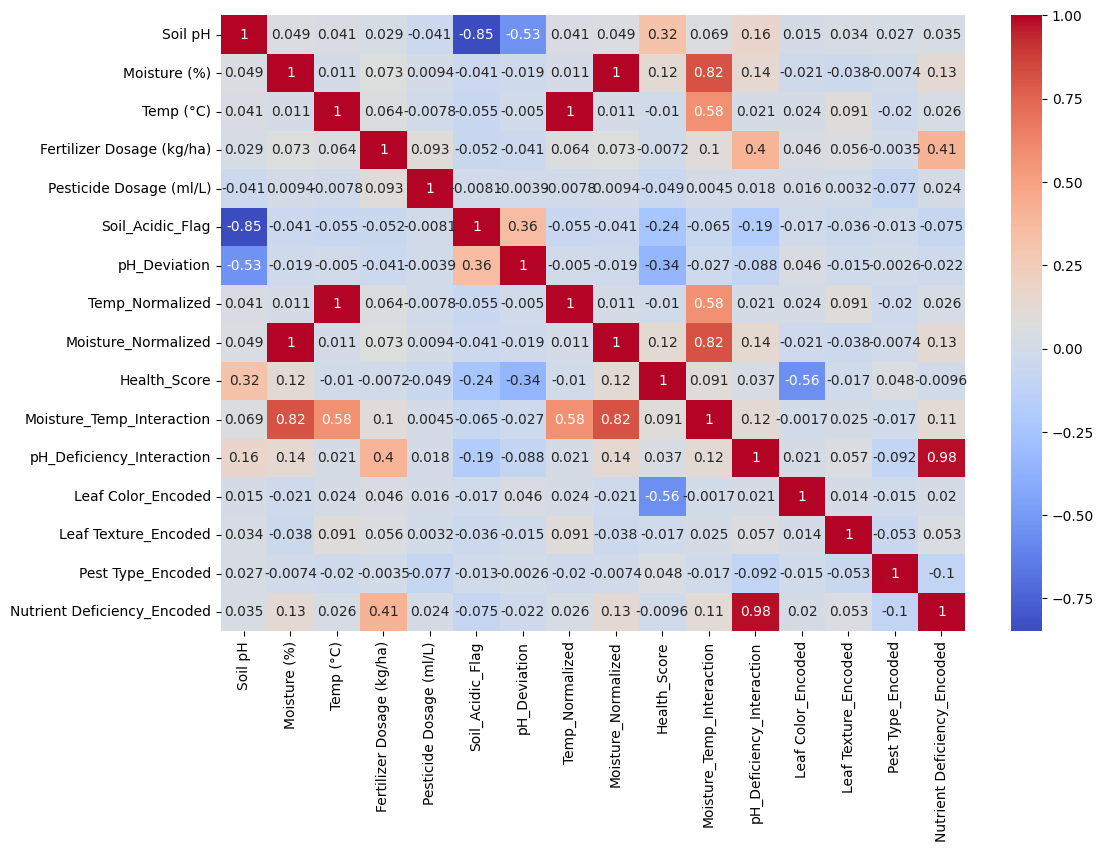

In [21]:
# 2. Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")

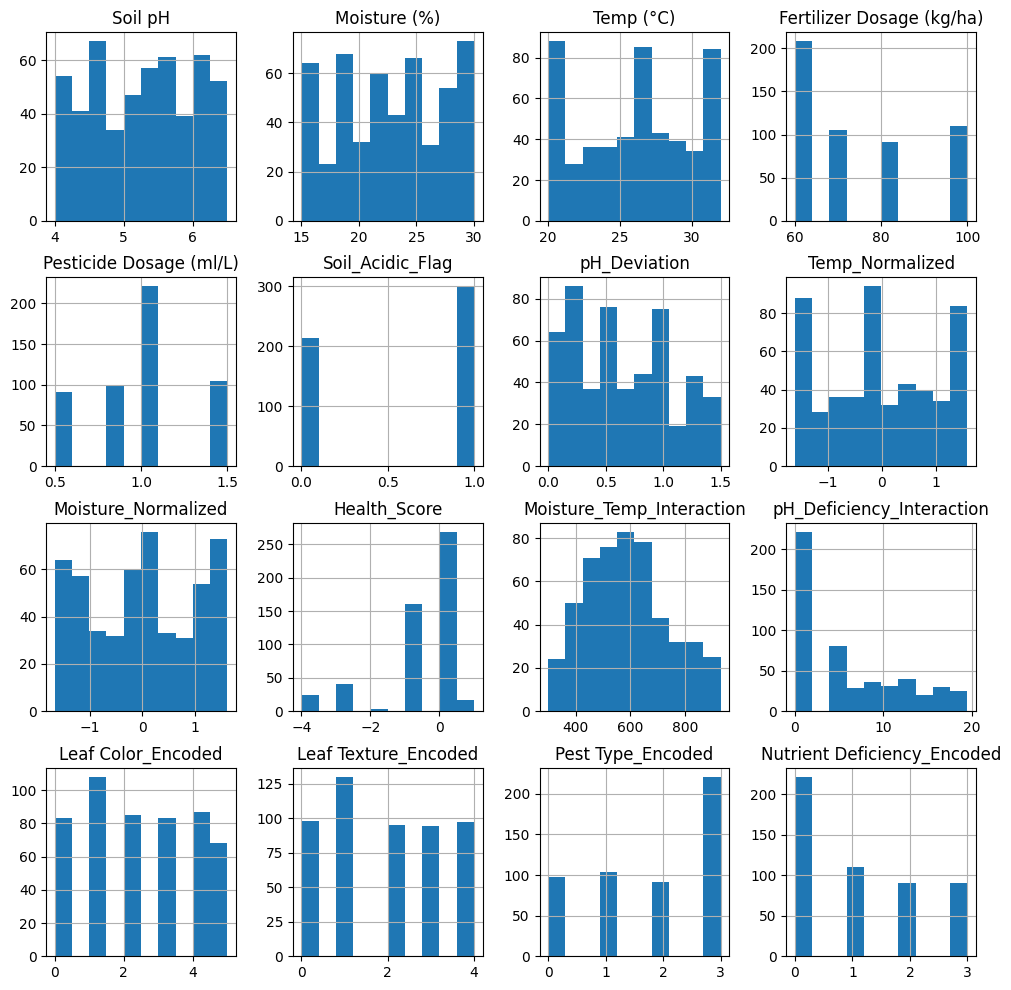

In [22]:
# 3. Distributions
df.hist(figsize=(12,12))
plt.show()


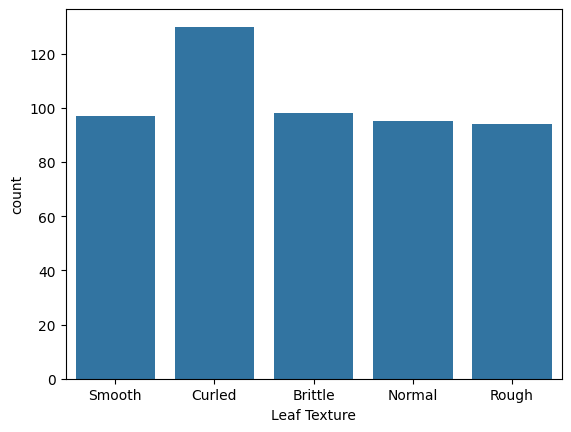

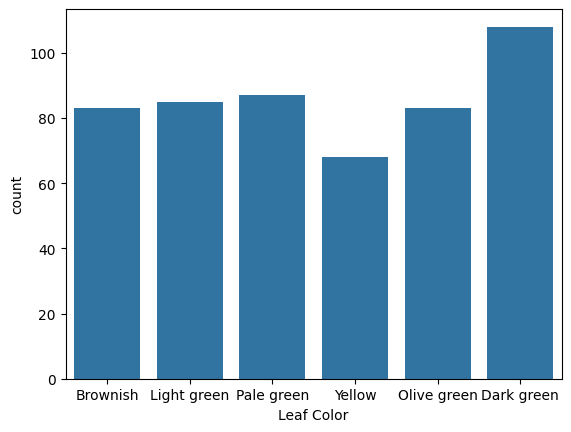

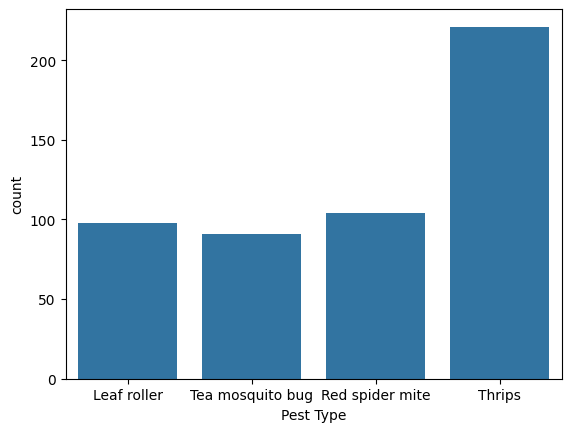

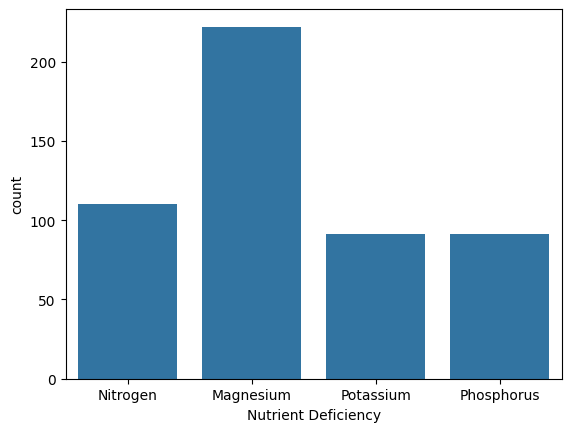

In [23]:
# 4. Countplots for categorical columns
sns.countplot(data=df, x="Leaf Texture")
plt.show()
sns.countplot( data=df, x="Leaf Color")
plt.show()
sns.countplot( data=df, x="Pest Type")
plt.show()
sns.countplot(data=df, x="Nutrient Deficiency")
plt.show()

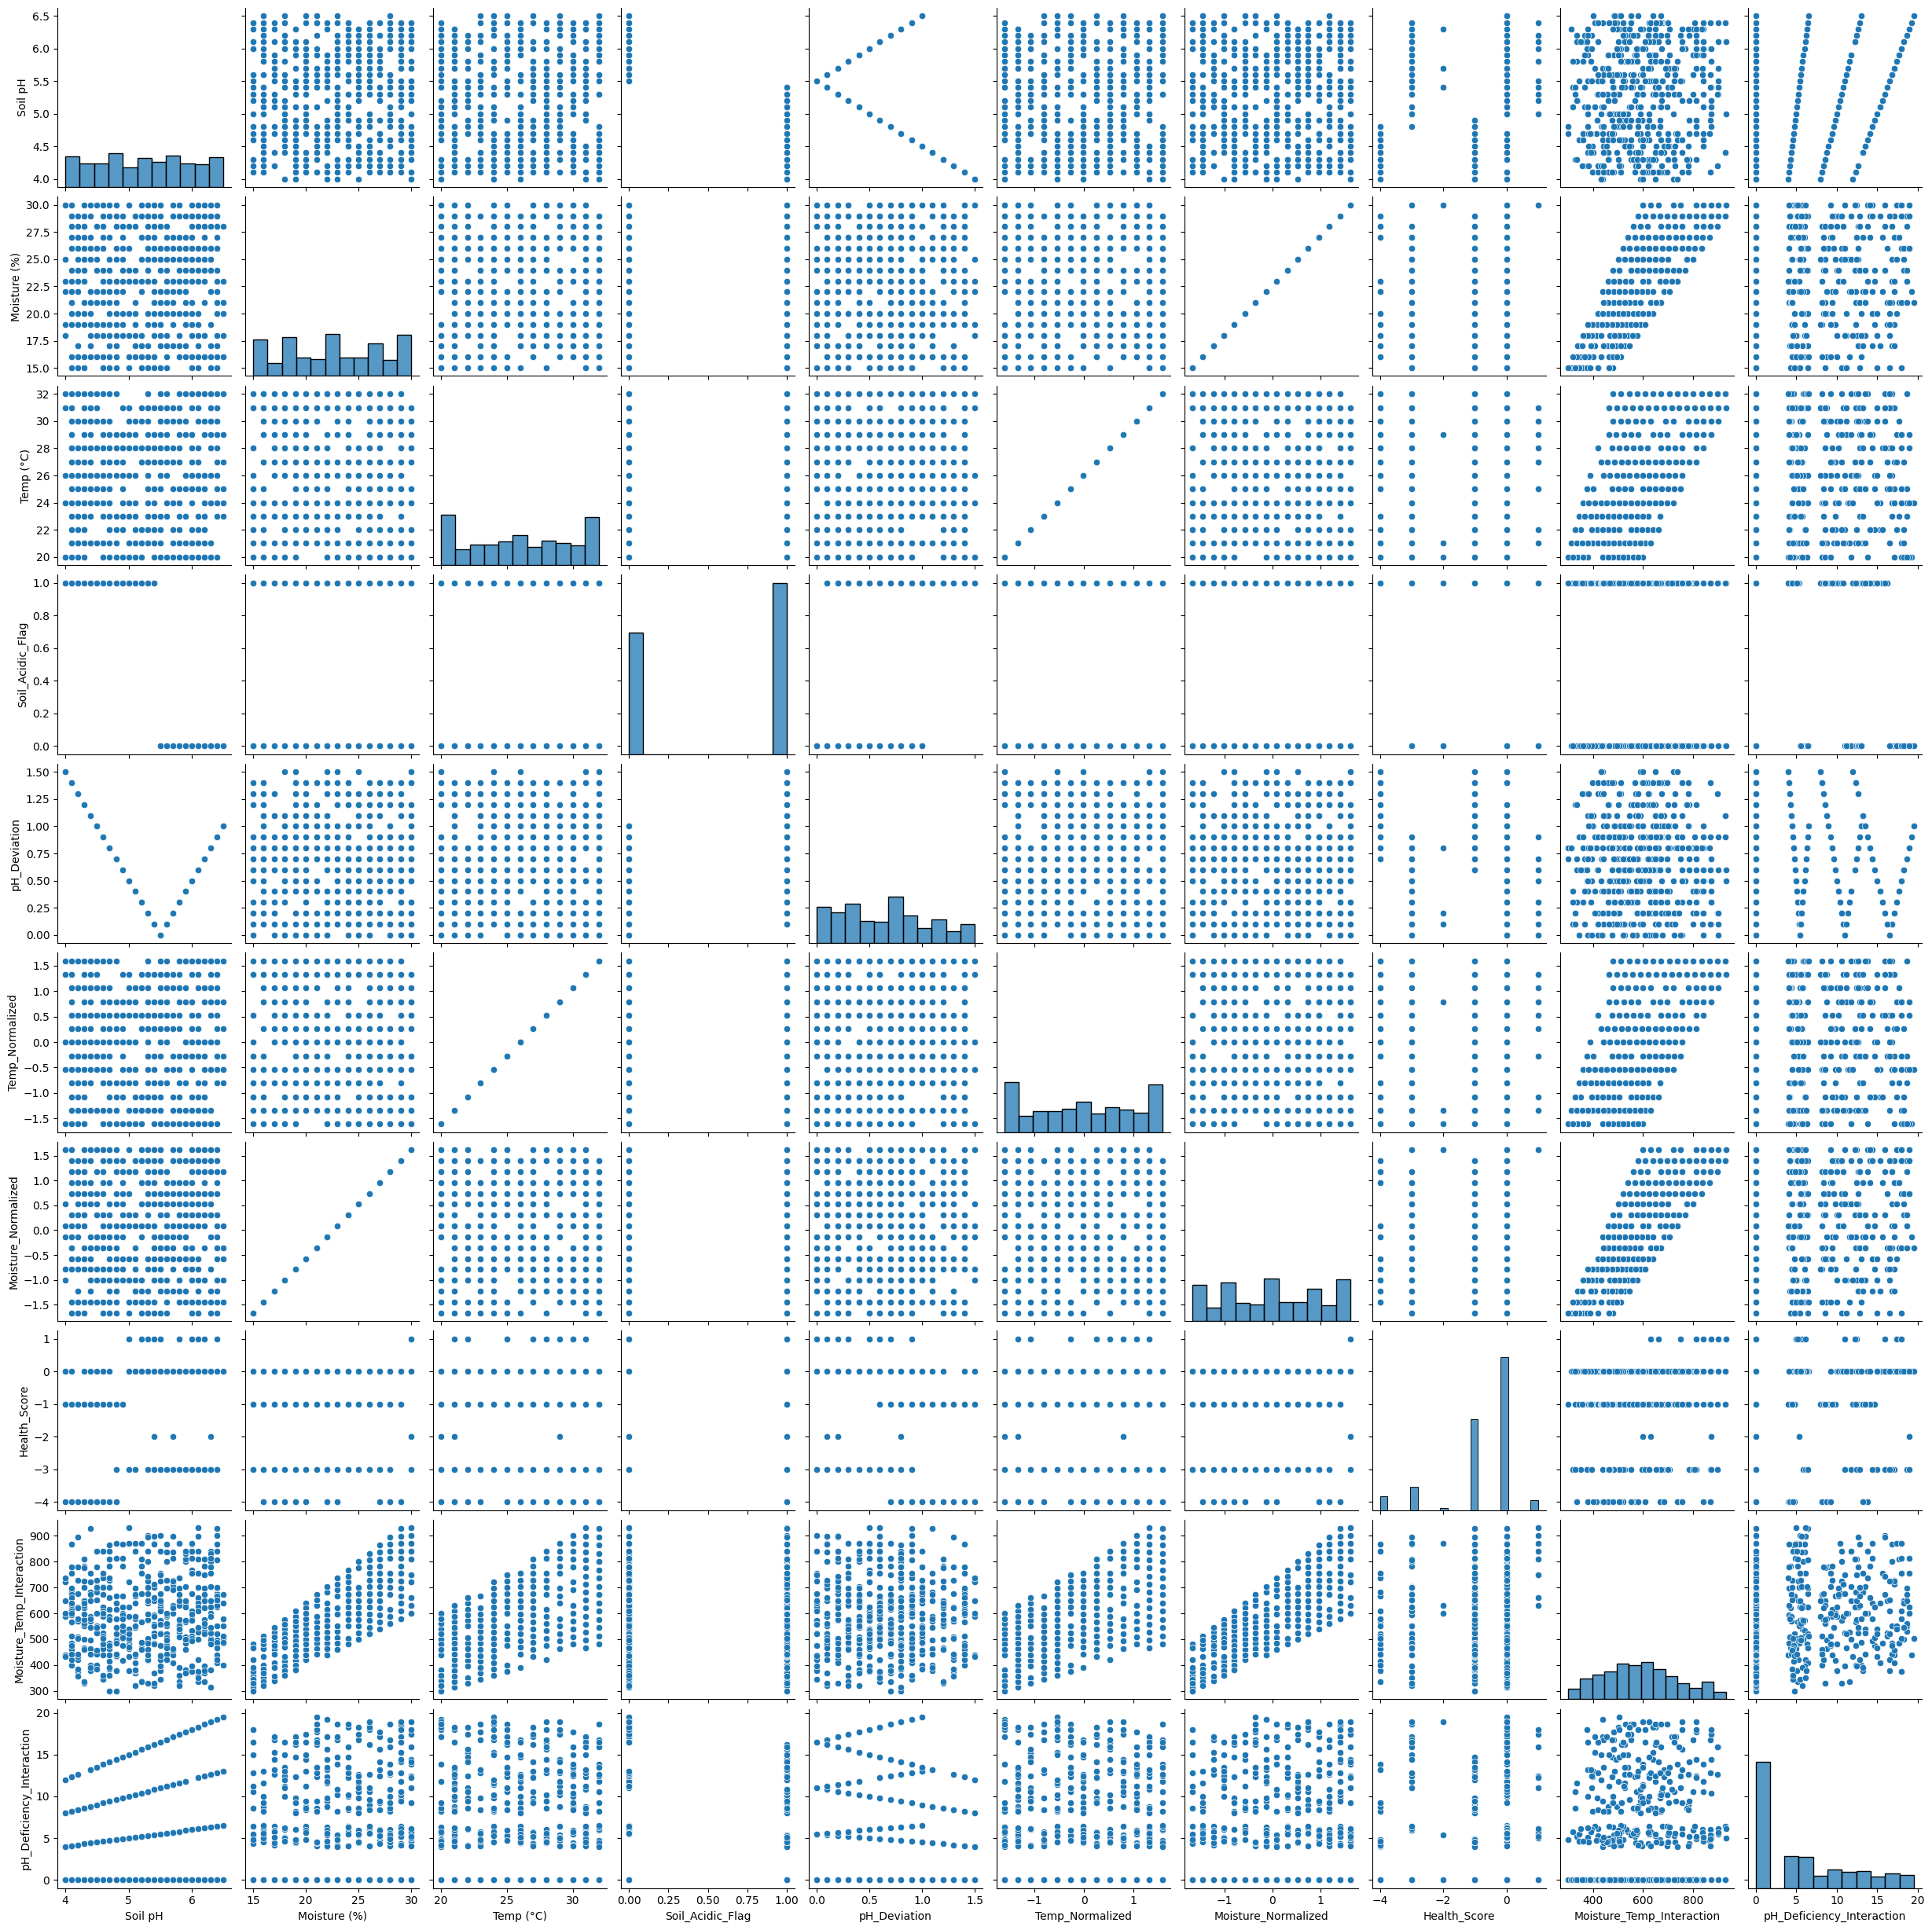

In [24]:
# 5. Pairplot
sns.pairplot(df[["Soil pH", "Moisture (%)", "Temp (°C)",
    "Soil_Acidic_Flag", "pH_Deviation", "Temp_Normalized",
    "Moisture_Normalized", "Health_Score",
    "Moisture_Temp_Interaction", "pH_Deficiency_Interaction",
    ]])
plt.show()

Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())

# Fit the model on the full training data
model.fit(X_train, y_train)

Cross-validation scores: [0.98795181 0.98780488 0.95121951 0.95121951 0.95121951]
Mean cross-validation accuracy: 0.9658830443726124


RandomForestClassifier()

Evaluating random forest

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9902912621359223

Classification Report:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.96      1.00      0.98        23
       Chlorpyrifos 20% EC       1.00      1.00      1.00        39
     Imidacloprid 17.8% SL       1.00      0.95      0.97        19
Lambda-cyhalothrin 2.5% EC       1.00      1.00      1.00        22

                  accuracy                           0.99       103
                 macro avg       0.99      0.99      0.99       103
              weighted avg       0.99      0.99      0.99       103



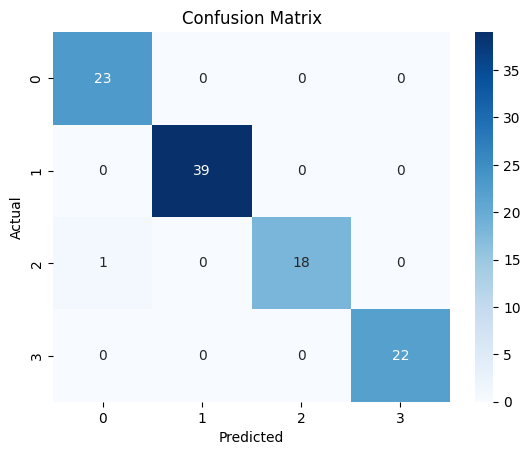

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Hyperparameter tuning

In [28]:
from sklearn.model_selection import GridSearchCV
params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), params, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_


Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

#Decision tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
import matplotlib.pyplot as plt


X = df[[
    "Soil pH","Moisture (%)","Temp (°C)",
    "Leaf Color_Encoded","Leaf Texture_Encoded",
    "Pest Type_Encoded","Nutrient Deficiency_Encoded",
    "Soil_Acidic_Flag","Health_Score"
]]

# Target (change to Recommended Fertilizer if needed)
y = df["Recommended Pesticide"]

In [31]:
#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [32]:
#TRAIN MODEL
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=4
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=4)

In [33]:
#preds
y_pred = dt.predict(X_test)

In [34]:
# --- EVALUATION ---
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.912621359223301

Classification Report:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.81      1.00      0.89        21
       Chlorpyrifos 20% EC       1.00      0.86      0.93        44
     Imidacloprid 17.8% SL       0.94      0.89      0.91        18
Lambda-cyhalothrin 2.5% EC       0.86      0.95      0.90        20

                  accuracy                           0.91       103
                 macro avg       0.90      0.93      0.91       103
              weighted avg       0.92      0.91      0.91       103



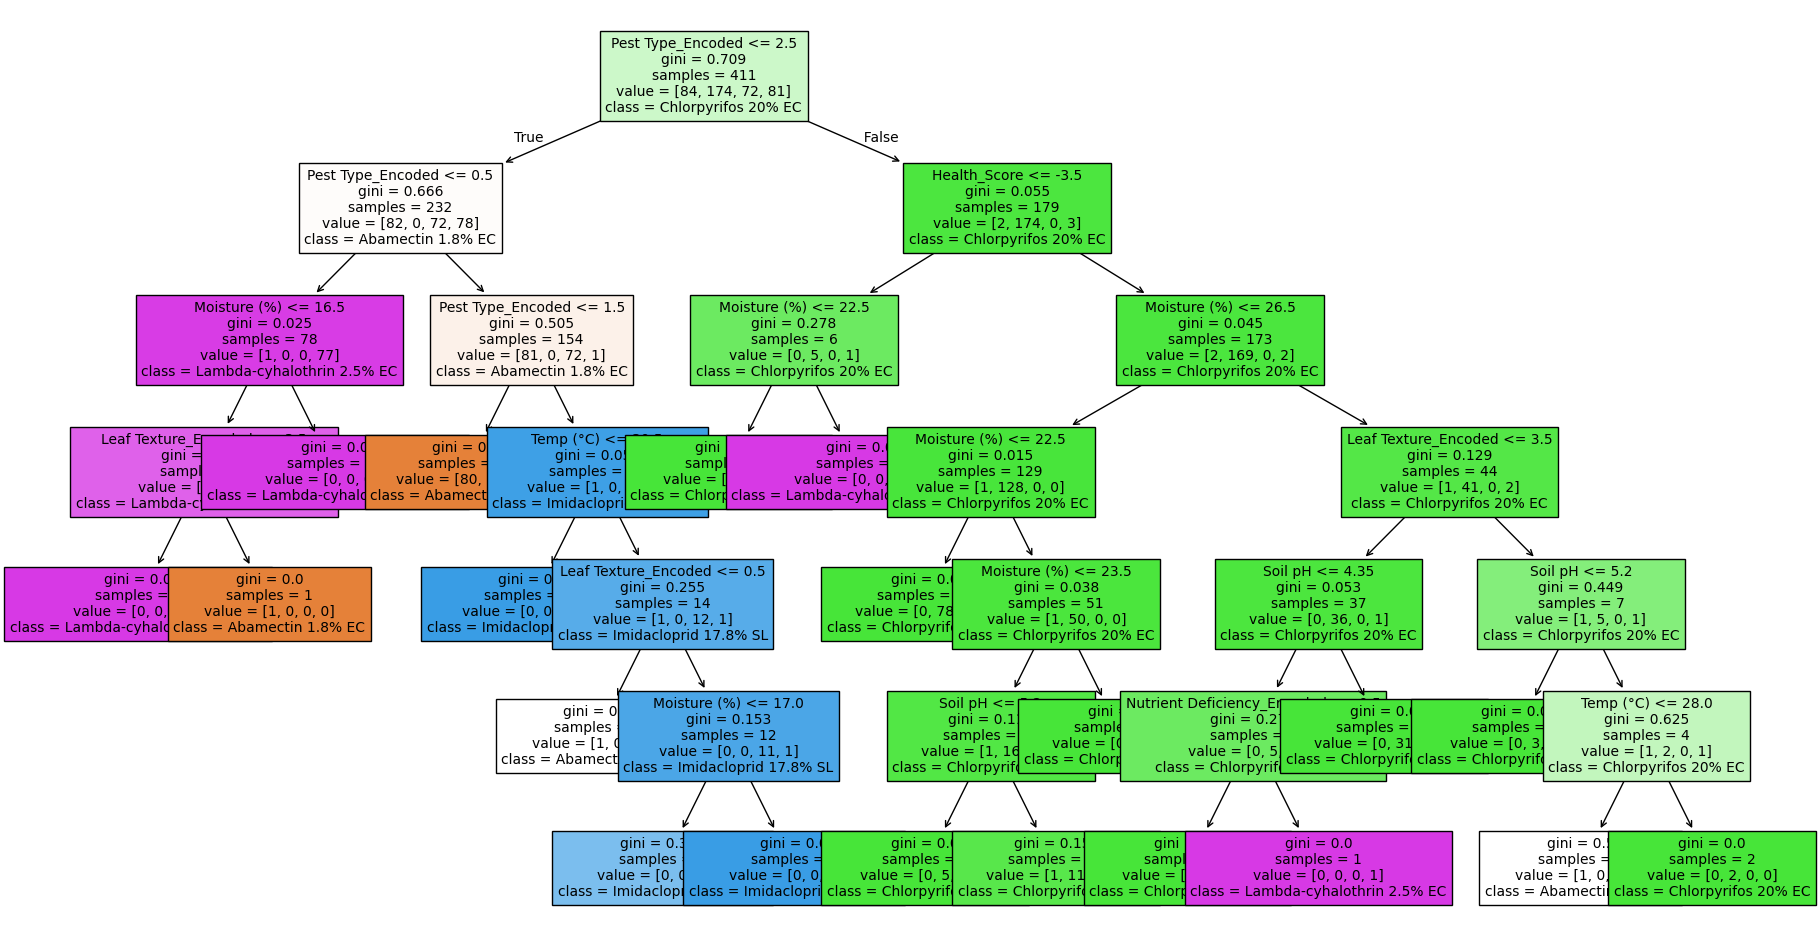

In [35]:
# --- VISUALIZE TREE ---
plt.figure(figsize=(22,12))
tree.plot_tree(
    dt,
    feature_names=X.columns,
    class_names=dt.classes_,
    filled=True,
    fontsize=10
)
plt.show()

In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

#Decision tree and random forest comparison

In [37]:
from sklearn.metrics import accuracy_score, classification_report

print("DECISION TREE ACCURACY:", accuracy_score(y_test, dt_pred))
print("\nDECISION TREE CLASSIFICATION REPORT:\n", classification_report(y_test, dt_pred))

print("RANDOM FOREST ACCURACY:", accuracy_score(y_test, rf_pred))
print("\nRANDOM FOREST CLASSIFICATION REPORT:\n", classification_report(y_test, rf_pred))


DECISION TREE ACCURACY: 0.9320388349514563

DECISION TREE CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.81      1.00      0.89        21
       Chlorpyrifos 20% EC       1.00      0.91      0.95        44
     Imidacloprid 17.8% SL       0.94      0.89      0.91        18
Lambda-cyhalothrin 2.5% EC       0.95      0.95      0.95        20

                  accuracy                           0.93       103
                 macro avg       0.92      0.94      0.93       103
              weighted avg       0.94      0.93      0.93       103

RANDOM FOREST ACCURACY: 0.17475728155339806

RANDOM FOREST CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.16      0.19      0.17        21
       Chlorpyrifos 20% EC       0.31      0.27      0.29        44
     Imidacloprid 17.8% SL       0.06      0.06      0.06        18
Lambda-cyhaloth

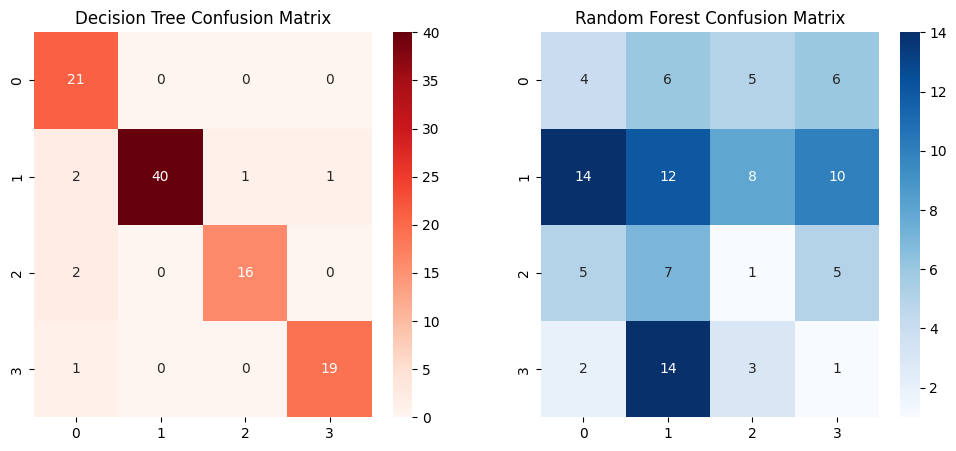

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, cmap="Reds")
plt.title("Decision Tree Confusion Matrix")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, cmap="Blues")
plt.title("Random Forest Confusion Matrix")

plt.show()


try bagging and boosting methods

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize a base estimator (e.g., Decision Tree)
bc = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42)

# Train the BaggingClassifier
bc.fit(X_train, y_train)

# Make predictions
bc_pred = bc.predict(X_test)

# Evaluate the model
print("BAGGGING CLASSIFIER ACCURACY:", accuracy_score(y_test, bc_pred))
print("\nBAGGGING CLASSIFIER CLASSIFICATION REPORT:\n", classification_report(y_test, bc_pred))

BAGGGING CLASSIFIER ACCURACY: 0.9611650485436893

BAGGGING CLASSIFIER CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.88      1.00      0.93        21
       Chlorpyrifos 20% EC       1.00      0.95      0.98        44
     Imidacloprid 17.8% SL       0.94      0.89      0.91        18
Lambda-cyhalothrin 2.5% EC       1.00      1.00      1.00        20

                  accuracy                           0.96       103
                 macro avg       0.95      0.96      0.96       103
              weighted avg       0.96      0.96      0.96       103



In [40]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize base estimator (RandomForestClassifier)
rf_bagging = BaggingClassifier(estimator=RandomForestClassifier(random_state=42), n_estimators=100, random_state=42)

# Train the BaggingClassifier with RandomForest
rf_bagging.fit(X_train, y_train)

# Make predictions
rf_bagging_pred = rf_bagging.predict(X_test)

print("RANDOM FOREST BAGGING ACCURACY:", accuracy_score(y_test, rf_bagging_pred))
print("\nRANDOM FOREST BAGGING CLASSIFICATION REPORT:\n", classification_report(y_test, rf_bagging_pred))

RANDOM FOREST BAGGING ACCURACY: 0.9611650485436893

RANDOM FOREST BAGGING CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.88      1.00      0.93        21
       Chlorpyrifos 20% EC       1.00      0.95      0.98        44
     Imidacloprid 17.8% SL       0.94      0.89      0.91        18
Lambda-cyhalothrin 2.5% EC       1.00      1.00      1.00        20

                  accuracy                           0.96       103
                 macro avg       0.95      0.96      0.96       103
              weighted avg       0.96      0.96      0.96       103



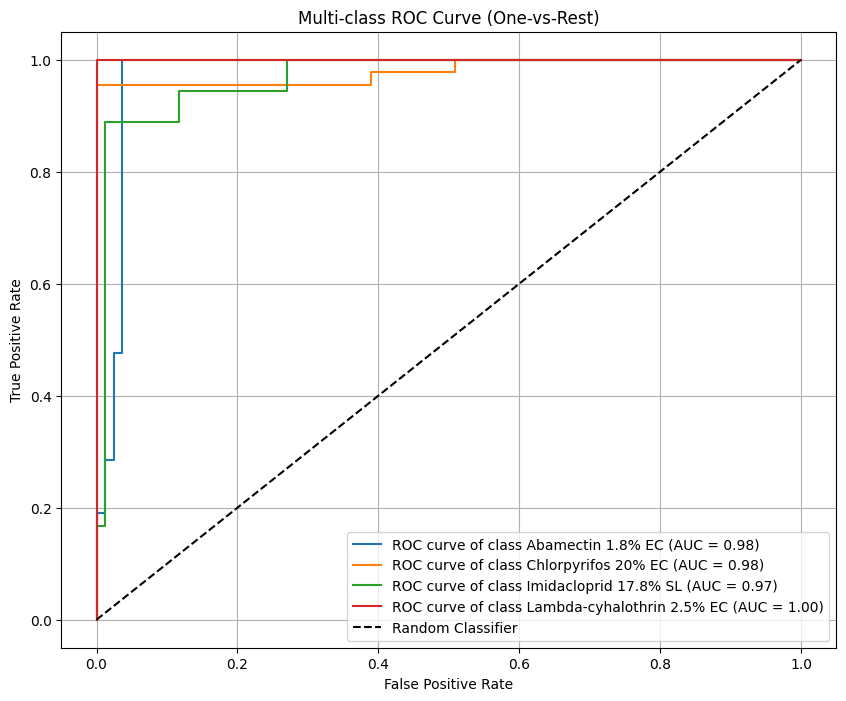

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Initialize LabelBinarizer
label_binarizer = LabelBinarizer()
y_test_binarized = label_binarizer.fit_transform(y_test)

# Get predicted probabilities from the best performing model (rf_bagging)
y_pred_proba = rf_bagging.predict_proba(X_test)

# Plot ROC AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_binarizer.classes_)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {label_binarizer.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)

# Make predictions
gbc_pred = gbc.predict(X_test)

# Evaluate the model
print("GRADIENT BOOSTING CLASSIFIER ACCURACY:", accuracy_score(y_test, gbc_pred))
print("\nGRADIENT BOOSTING CLASSIFIER CLASSIFICATION REPORT:\n", classification_report(y_test, gbc_pred))

GRADIENT BOOSTING CLASSIFIER ACCURACY: 0.9514563106796117

GRADIENT BOOSTING CLASSIFIER CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

         Abamectin 1.8% EC       0.84      1.00      0.91        21
       Chlorpyrifos 20% EC       1.00      0.95      0.98        44
     Imidacloprid 17.8% SL       0.94      0.89      0.91        18
Lambda-cyhalothrin 2.5% EC       1.00      0.95      0.97        20

                  accuracy                           0.95       103
                 macro avg       0.95      0.95      0.94       103
              weighted avg       0.96      0.95      0.95       103



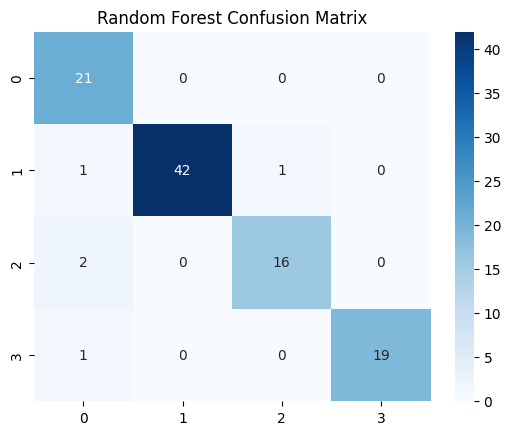

In [43]:
sns.heatmap(confusion_matrix(y_test, gbc_pred), annot=True, cmap="Blues")
plt.title("Random Forest Confusion Matrix")

plt.show()

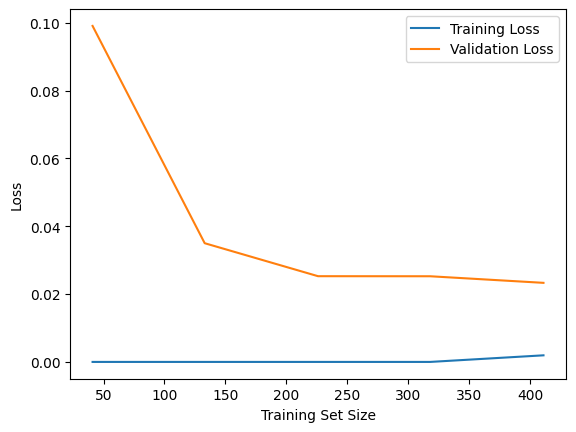

In [49]:
from sklearn.model_selection import learning_curve

rf_model = RandomForestClassifier()

train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X, y, cv=5, scoring='accuracy'
)

train_error = 1 - np.mean(train_scores, axis=1)
val_error = 1 - np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_error, label="Training Loss")
plt.plot(train_sizes, val_error, label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Loss")
plt.legend()
plt.show()

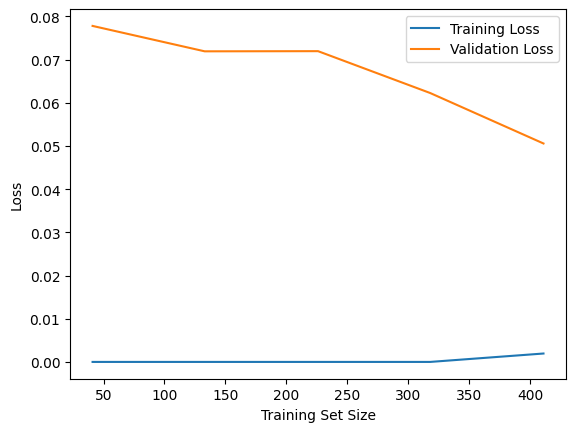

In [50]:
dt_model = DecisionTreeClassifier()

train_sizes, train_scores, val_scores = learning_curve(
    dt_model, X, y, cv=5, scoring='accuracy'
)

train_error = 1 - np.mean(train_scores, axis=1)
val_error = 1 - np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_error, label="Training Loss")
plt.plot(train_sizes, val_error, label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Loss")
plt.legend()
plt.show()